# Sentinel-1 Data

This notebook aims to test some Data Cube functions using Sentinel-1 data

First... we do all the necessary imports !

In [2]:
%matplotlib inline
# necessary for plot display in jupyter

from datetime import date
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy
import time
from datacube.api.model import DatasetType, Satellite, BANDS, S1Bands
from datacube.api.query import list_tiles_as_list
from datacube.api.utils import get_dataset_data, get_dataset_metadata
from eotools.tiling import generate_tiles
from eotools.coordinates import convert_coordinates
from idl_functions import histogram
from math import log10
from scipy import optimize
from scipy import interpolate
from scipy import signal
#import ogr
#import pandas
#from idl_functions import hist_equal
#from idl_functions import label_region
#from image_processing.segmentation import SegmentVisitor

In [3]:
import sys

def my_print(text):
    sys.stdout.write(str(text))
    sys.stdout.flush()

#### We define all the parameters we want to retrieve the data

In [4]:
dataset_types = [DatasetType.SIGMA_VV]
min_date = date(2015, 9, 1)
max_date = date(2015, 12, 31)
satellites = [Satellite(i) for i in ['S1']]
x_cell = [88,89,90,91]
y_cell = [25,26]

#### We request the tiles according to the parameters and we check that we have the 6 tiles corresponding to our Landsat image

In [5]:
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)

In [5]:
print "Number of time periods: {}".format(len(tiles))

#### Method to get data from a tile

In [7]:
def getDatasetFromTile(tile):
    dataset = tile.datasets[DatasetType.SIGMA_VV]
    data = get_dataset_data(dataset)
    metadata = get_dataset_metadata(dataset)
    samples, lines = metadata.shape
    print "Tile file path location: {path}".format(path=dataset.path)
    print "Array dimensions:\nx: {x} & y: {y}".format(x=samples, y=lines)
    return data

In [8]:
data = getDatasetFromTile(tiles[2])

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


#### Method to display a tile. If a threshold is given as parameter, a mask is applied.

In [9]:
def showDataset(data, threshold=None):
    matrix = np.reshape(data.get(S1Bands.SIGMA_VV), (-1, 4000))
    plt.figure()
    if (threshold == None):
        plt.imshow(matrix, cmap = cm.Greys_r, vmin=0, vmax=1)
    else:
        thresh = (matrix[:, :] > 0) & (matrix[:, :] < threshold)
        plt.imshow(thresh, cmap=cm.gray)
    plt.colorbar()
    plt.show()
    plt.close()

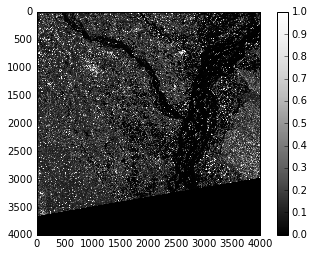

In [9]:
showDataset(data)

In [10]:
print "Min",data.get(S1Bands.SIGMA_VV).min()
print "Max",data.get(S1Bands.SIGMA_VV).max()

Min -28672.0
Max 241.925


#### Method to remove all NO_DATA (= -28672 in Data Cube) and to apply a log function on data.

In [11]:
def getLogFilteredNoDataAndZeros(data):
    allVal = []
    for val in (data.get(S1Bands.SIGMA_VV)).flatten():
        if val > 0:
            allVal.append(log10(val))
    return allVal

In [12]:
allVal = getLogFilteredNoDataAndZeros(data)

#### Method to display histogram of the values in the tile

In [13]:
def showHistogram(data):
    (n, bins) = np.histogram(data, bins=100, range=[-8,3])  # NumPy version (no plot)
    plt.figure()
    plt.plot(.5*(bins[1:]+bins[:-1]), n)
    plt.show()
    plt.close()

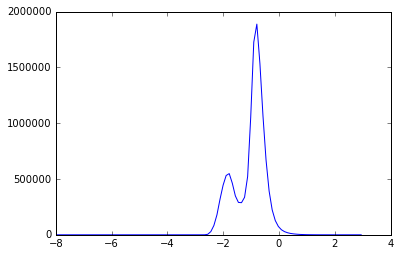

In [14]:
showHistogram(allVal)

#### Method to compute the threshold of a tile

In [15]:
def bimodalHistDetection(imageFlatenned, nbOfMiniIntervals, stdFiltering, minOc):
    minval= numpy.min(imageFlatenned) 
    maxval= numpy.max(imageFlatenned)
    meanval = numpy.mean(imageFlatenned)
    stddevval = numpy.std(imageFlatenned)

    print 'Min Val:',minval
    print 'Max Val:',maxval
    print 'Mean Val:',meanval
    print 'Std dev Val:',stddevval

    # create a table of 256 evenly spaced values between minimum value and maximum value
    tabX = numpy.linspace(minval, maxval, 256)
    # create a table [0,...,255]
    tabY = numpy.arange(256)

    # interpolation functions
    finterp1 = interpolate.interp1d(tabX,tabY,kind='nearest')
    finterp2 = interpolate.interp1d(tabY,tabX,kind='linear')

    # interpolate with nearest function input data
    newValues = finterp1(imageFlatenned) 

    # histogram of the data on 256 bins 
    hist, bins = numpy.histogram(newValues, bins=256, range=(0,255))

    xss = finterp2(tabY)

    #plt.figure()
    #plt.bar(xs, hist, color="black")
    #plt.show()
    #plt.close()

    window = signal.gaussian(51, std = stdFiltering)
    hist_filtered = numpy.convolve(hist, window/window.sum(),mode='same')
    hist_filtered_interp = interpolate.interp1d(xss,hist_filtered,kind='linear')

    funct = lambda xss : hist_filtered_interp(xss)
    funct_neg = lambda xss : -hist_filtered_interp(xss)

    eps = 1.e-4
    delta = (maxval - minval)/nbOfMiniIntervals 
    delta = delta - (delta/1000.) 

    # find xmin of minimum using loop 
    tabValMin = []
    tabValMax = []

    bmin = minval
    for i in range(nbOfMiniIntervals):
        bmax = bmin + delta
        # print 'bmin',bmin
        # print 'bmax',bmax
        xmin = optimize.fminbound(funct, bmin, bmax)
        xmax = optimize.fminbound(funct_neg, bmin, bmax)
        if (numpy.abs(xmin - bmin) > eps and numpy.abs(xmin - bmax) > eps and funct(xmin) > minOc):
            tabValMin.append(xmin)
        if (numpy.abs(xmax - bmin) > eps and numpy.abs(xmax - bmax) > eps and funct(xmax) > minOc):
            tabValMax.append(xmax)
        bmin = bmax

    f_minval = numpy.min(hist_filtered_interp(xss))
    f_maxval = numpy.max(hist_filtered_interp(xss))
    total_f_variation = numpy.abs(f_maxval - f_minval)

    tabValMin = numpy.array(tabValMin)
    print 'tabValMin:',tabValMin

    tabValMax = numpy.array(tabValMax)
    print 'tabValMax:',tabValMax

    if numpy.size(tabValMin) != 0 and numpy.size(tabValMax) != 0:    
        f_tabValMin = funct(tabValMin)
        max_f_tabValMin = numpy.max(f_tabValMin)
        f_tabValMax = funct(tabValMax)
        min_f_tabValMax = numpy.min(f_tabValMax)
        local_f_min_variation = numpy.abs(min_f_tabValMax - max_f_tabValMin)
        sharpness = (local_f_min_variation/total_f_variation)*100

    else:
        tabValMin = []
        sharpness = 0
        tabValMin = numpy.array(tabValMin)
        f_tabValMin = 40
    
    return sharpness,tabValMin,f_tabValMin

In [16]:
def computeThresholdOnPreprocessedTile(tablin, nbOfMiniIntervals = 20, stdFiltering = 3.5, sharpnessLimit=3.0, minOc=1000): 
    nantest = numpy.where(numpy.isnan(tablin), 1, 0)
    zerotest = numpy.where(tablin == 0, 1, 0)
    # print 'Number of NaN',numpy.sum(nantest)
    # print 'Number of Zero',numpy.sum(zerotest)
    min_tab_min = []
    sharpness = 0
        
    if (numpy.sum(nantest) == 0):
        if (numpy.sum(zerotest) == 0):
            sharpness, tabmin, f_tabmin = bimodalHistDetection(tablin, nbOfMiniIntervals, stdFiltering, minOc)
            if sharpness > sharpnessLimit:
                min_tab_min.append(numpy.min(tabmin))

    return sharpness, min_tab_min

In [17]:
sharpness, min_tab_min = computeThresholdOnPreprocessedTile(allVal)
print sharpness
print min_tab_min
print pow(10,min_tab_min[0])

Min Val: -2.7829867526
Max Val: 2.3836807552
Mean Val: -1.02816907214
Std dev Val: 0.536839021887
tabValMin: [-1.38494787]
tabValMax: [-1.83069799 -0.81762726]
13.5531732001
[-1.3849478693445947]
0.0412146988303


#### We compute the threshold for each tile of our Sentinel-1 image

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


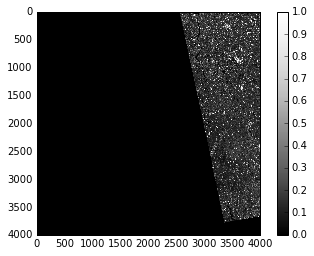

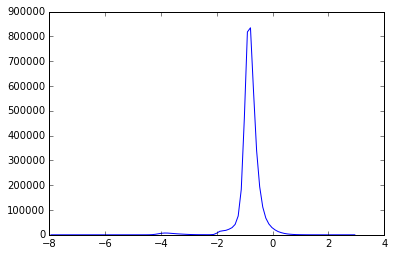

Min Val: -4.83824074322
Max Val: 2.25117268372
Mean Val: -0.835071837892
Std dev Val: 0.446564914703
tabValMin: []
tabValMax: [-3.80958478 -0.83480785]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


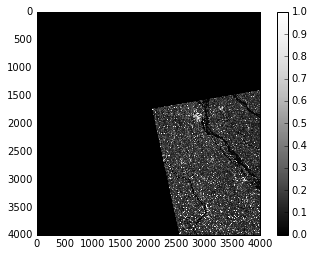

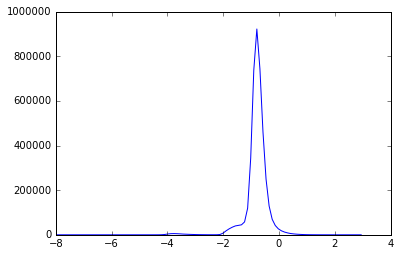

Min Val: -4.54275340811
Max Val: 1.92861419288
Mean Val: -0.801556280512
Std dev Val: 0.407419123743
tabValMin: []
tabValMax: [-3.75604103 -0.78682192]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


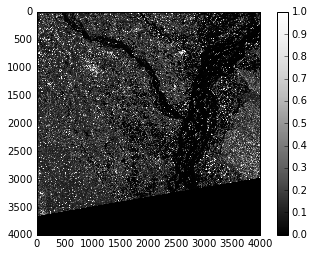

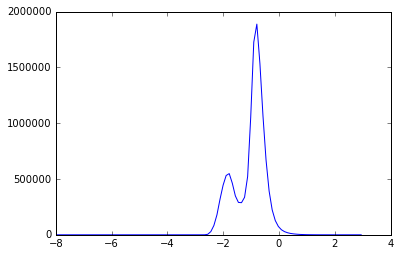

Min Val: -2.7829867526
Max Val: 2.3836807552
Mean Val: -1.02816907214
Std dev Val: 0.536839021887
tabValMin: [-1.38494787]
tabValMax: [-1.83069799 -0.81762726]
Threshold: -1.38494786934
Sharpness: 13.5531732001

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


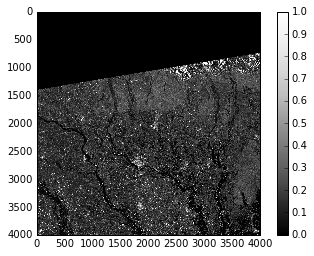

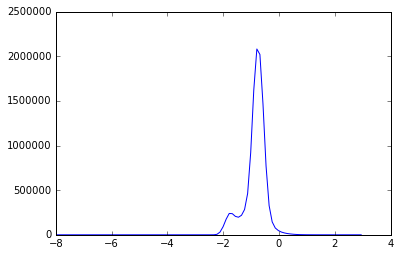

Min Val: -2.53357200153
Max Val: 2.15379589033
Mean Val: -0.851265023873
Std dev Val: 0.378389662582
tabValMin: [-1.46742626]
tabValMax: [-1.72477332 -0.75053356]
No threshold found.
Sharpness: 1.83558287606

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


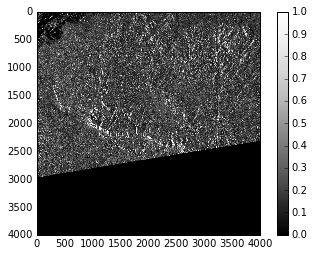

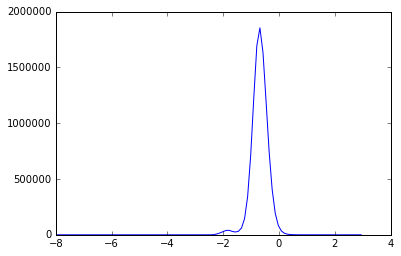

Min Val: -2.492432995
Max Val: 1.8741156052
Mean Val: -0.697502370251
Std dev Val: 0.297357830358
tabValMin: [-1.56775131]
tabValMax: [-1.8417292  -0.69444134]
No threshold found.
Sharpness: 0.753855720613

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


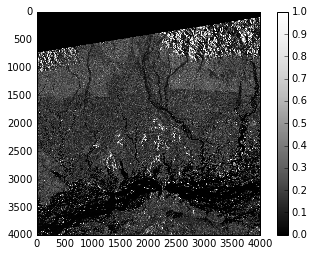

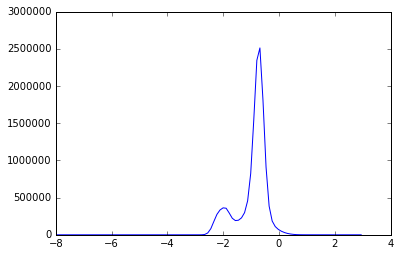

Min Val: -2.88709874037
Max Val: 1.98412677336
Mean Val: -0.945536748956
Std dev Val: 0.526389123522
tabValMin: [-1.53079579]
tabValMax: [-1.97016145 -0.72847684]
Threshold: -1.53079579446
Sharpness: 6.83094752009

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


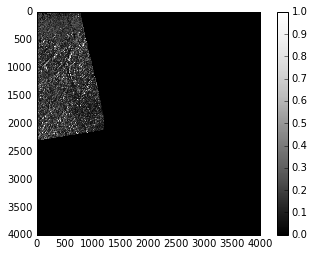

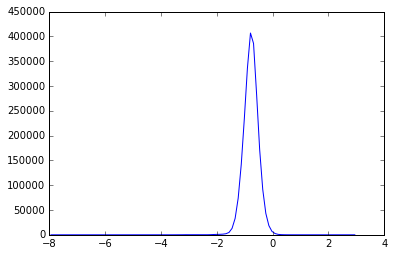

Min Val: -5.20023145977
Max Val: 1.46832109287
Mean Val: -0.77811567137
Std dev Val: 0.266054276106
tabValMin: []
tabValMax: [-0.75453068]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


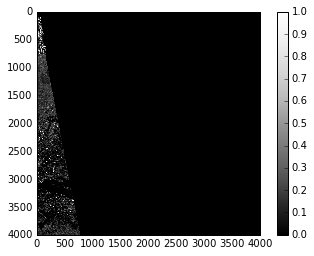

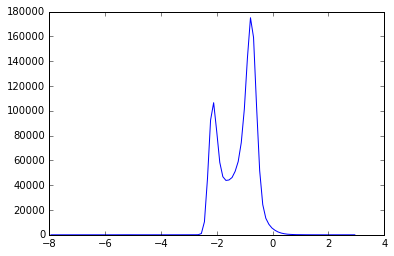

Min Val: -6.96885188705
Max Val: 2.58509518902
Mean Val: -1.24438647484
Std dev Val: 0.623284470888
tabValMin: [-1.61114759]
tabValMax: [-2.09821345 -0.78688395]
Threshold: -1.61114758592
Sharpness: 27.7903436168

##########

Finished handling tiles.


In [18]:
thresholds = []
for tile in tiles:
    tileDataset = getDatasetFromTile(tile)
    showDataset(tileDataset)
    filteredData = getLogFilteredNoDataAndZeros(tileDataset)
    showHistogram(filteredData)
    sharpness, value = computeThresholdOnPreprocessedTile(filteredData)
    if len(value) > 0:
        thresholds.append(value[0])
        my_print("Threshold: {0}\n".format(value[0]))
    else:
        my_print("No threshold found.\n")
    my_print("Sharpness: {0}\n".format(sharpness))
    my_print("\n")
    my_print("##########\n")
    my_print("\n")
print "Finished handling tiles."

#### Method to compute the global threshold of the product from thresholds of tiles

In [19]:
def get_threshold(thresholds) :
    min_tab_min = thresholds
    nbOfSplitNeeded = len(min_tab_min)
    min_tab_min = numpy.array(min_tab_min)
    min_val = numpy.min(min_tab_min)
    max_val = numpy.max(min_tab_min)

    tabX = numpy.linspace(numpy.min(min_tab_min), numpy.max(min_tab_min), 256)
    tabY = numpy.arange(256)
    finterp1 = interpolate.interp1d(tabX,tabY,kind='nearest')
    finterp2 = interpolate.interp1d(tabY,tabX,kind='linear')
    newValues = finterp1(min_tab_min) 

    hist, bins = numpy.histogram(newValues, bins=256, range=(0,255))

    xs = numpy.arange(len(hist))
    xss = finterp2(xs)

    window = signal.gaussian(51, std = 1)
    hist_filtered = numpy.convolve(hist, window/window.sum(),mode='same')
    hist_filtered_interp = interpolate.interp1d(xss,hist_filtered,kind='linear')
    hist_filtered_tab = hist_filtered_interp(xss)

    for i in range(len(xss)):
        if (hist_filtered_tab[i] != 0):
            minSeuil = xss[i]
            break

    funct = lambda xss : hist_filtered_interp(xss)
    funct_neg = lambda xss : -hist_filtered_interp(xss)

    nbOfIntervals = 60
    eps = 1.e-4
    delta = (max_val - min_val)/nbOfIntervals

    tabValMin = []
    tabValMax = []

    bmin = min_val
    for i in range(nbOfIntervals):
        bmax = bmin + delta
        xmin = optimize.fminbound(funct, bmin, bmax)
        xmax = optimize.fminbound(funct_neg, bmin, bmax)
        if (numpy.abs(xmin - bmin) > eps and numpy.abs(xmin - bmax) > eps):
            tabValMin.append(xmin)
        if (numpy.abs(xmax - bmin) > eps and numpy.abs(xmax - bmax) > eps):
            tabValMax.append(xmax)
        bmin = bmax

    tabValMin = numpy.array(tabValMin)
    tabValMax = numpy.array(tabValMax)

    f_tabValMin = funct(tabValMin)
    f_tabValMax = funct(tabValMax)
    
    plt.plot(xss, hist, color="black")
    plt.plot(xss,hist_filtered_tab, color="red")
    plt.plot(tabValMax,funct(tabValMax),'ro')
    plt.show()
    
    if (len(tabValMax) == 1):
        return tabValMax[0]
    else:
        return (tabValMax[0] + tabValMax[1])/2.

[-1.3849478693445947, -1.5307957944630373, -1.6111475859196507]


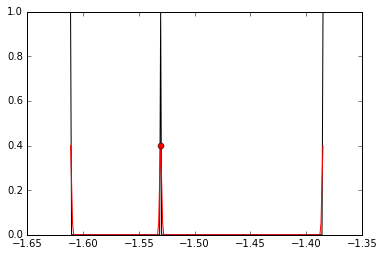

-1.53042321667
0.0294833469656


In [20]:
print thresholds
finalThreshold = get_threshold(thresholds)
print finalThreshold
finalThreshold = pow(10,finalThreshold)
print finalThreshold

#### We apply the global threshold to the product and display tiles with a mask

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


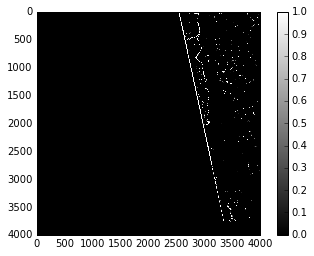

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


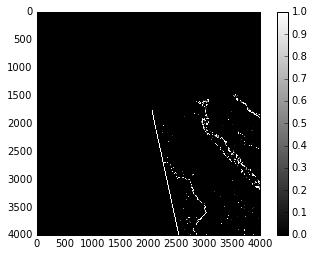

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


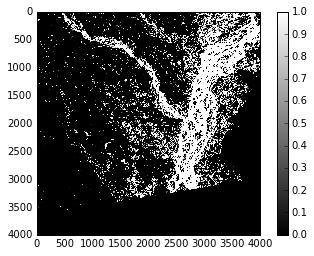

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


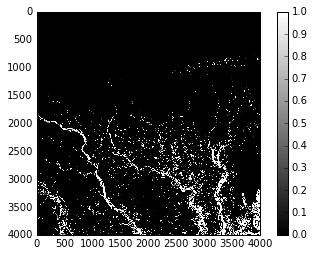

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


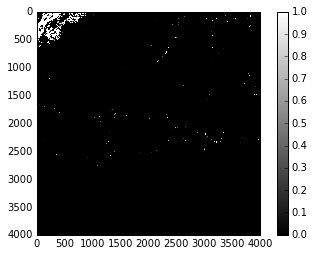

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


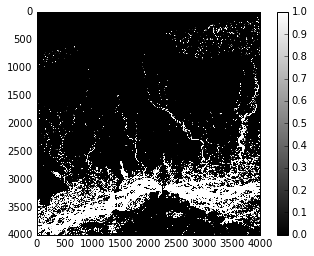

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


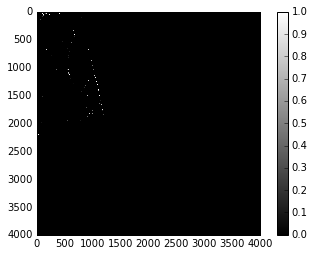

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


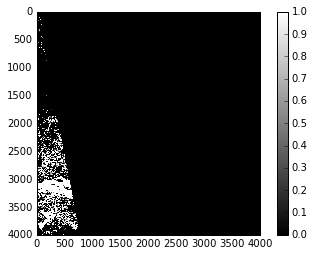

In [21]:
for tile in tiles:
    tileDataset = getDatasetFromTile(tile)
    showDataset(tileDataset, finalThreshold)

#### Now we want to do the same we the product before the flooding event

In [22]:
dataset_types = [DatasetType.SIGMA_VV]
min_date = date(2015, 6, 1)
max_date = date(2015, 9, 1)
satellites = [Satellite(i) for i in ['S1']]
x_cell = [88,89,90,91]
y_cell = [25,26]

In [23]:
tiles_before = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


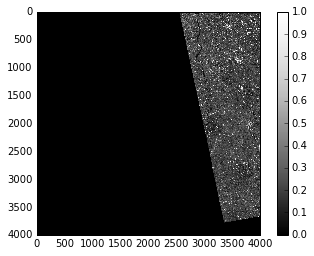

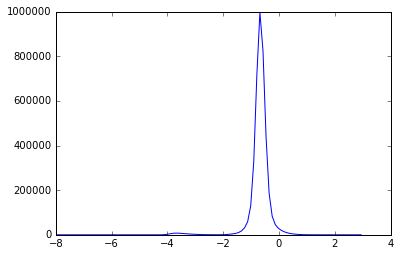

Min Val: -4.33831534503
Max Val: 2.32765026028
Mean Val: -0.694793771518
Std dev Val: 0.407096859435
tabValMin: []
tabValMax: [-3.65865046 -0.6785665 ]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


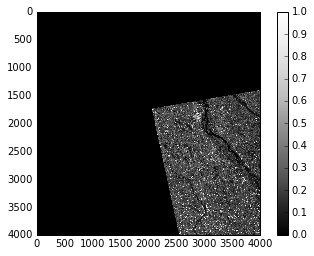

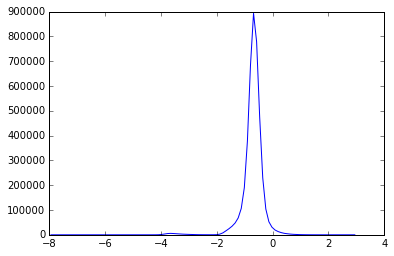

Min Val: -4.41010115432
Max Val: 1.92489384248
Mean Val: -0.708511053407
Std dev Val: 0.389016707005
tabValMin: []
tabValMax: [-3.63996492 -0.65879098]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


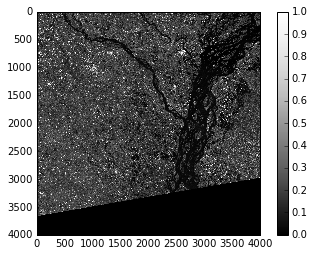

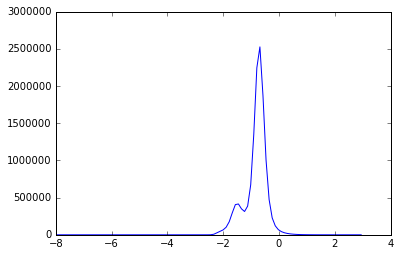

Min Val: -2.56402565368
Max Val: 2.23502035139
Mean Val: -0.82967520606
Std dev Val: 0.394184829382
tabValMin: [-1.24664103]
tabValMax: [-1.49129925 -0.70086745]
Threshold: -1.24664103022
Sharpness: 3.46283215527

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


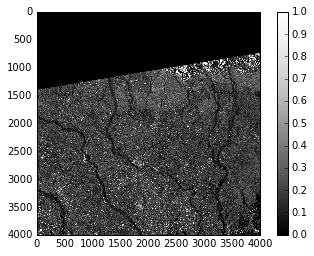

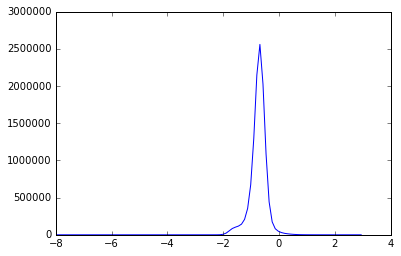

Min Val: -2.2996990812
Max Val: 2.22218143371
Mean Val: -0.738311747741
Std dev Val: 0.283939331484
tabValMin: []
tabValMax: [-0.68600848]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


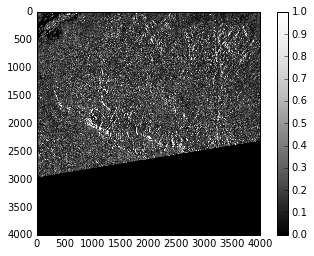

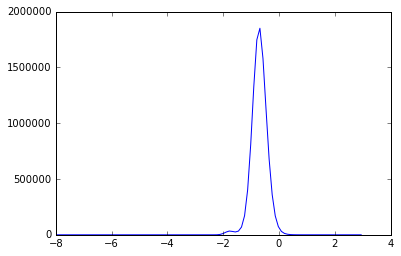

Min Val: -2.4146593167
Max Val: 1.8037378463
Mean Val: -0.70823047512
Std dev Val: 0.279850675835
tabValMin: [-1.57097996]
tabValMax: [-1.75295136 -0.71075636]
No threshold found.
Sharpness: 0.32211522687

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


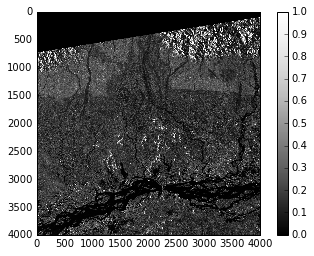

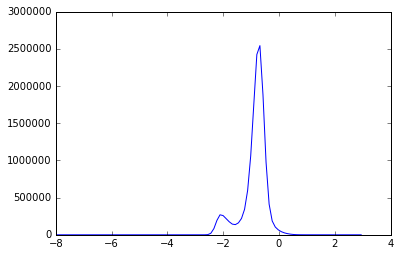

Min Val: -2.74348755655
Max Val: 1.87052171609
Mean Val: -0.88129786479
Std dev Val: 0.450192832776
tabValMin: [-1.60355284]
tabValMax: [-2.0740028  -0.71694387]
Threshold: -1.60355284437
Sharpness: 4.99299484836

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


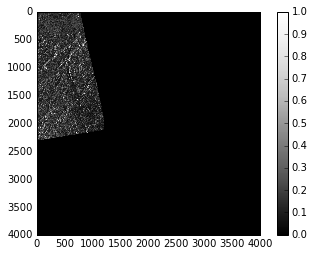

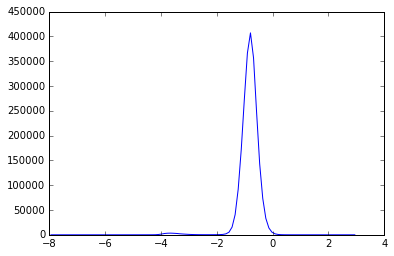

Min Val: -8.65912027101
Max Val: 1.4394184724
Mean Val: -0.838408197671
Std dev Val: 0.381765348285
tabValMin: []
tabValMax: [-3.66925038 -0.81789992]
No threshold found.
Sharpness: 0

##########

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


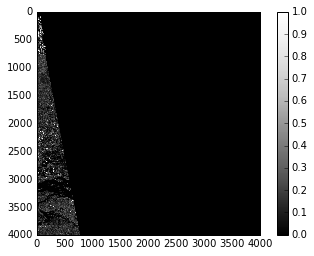

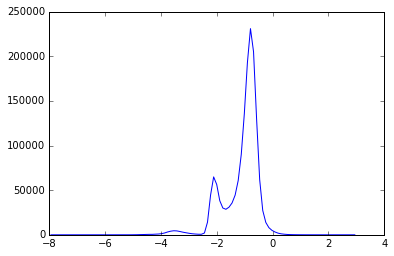

Min Val: -8.28091354539
Max Val: 1.7300468475
Mean Val: -1.11556386366
Std dev Val: 0.641866795848
tabValMin: [-1.64619973]
tabValMax: [-3.53061198 -2.07804189 -0.78250705]
Threshold: -1.64619973462
Sharpness: 14.254989067

##########

Finished handling tiles.


In [24]:
thresholds_before = []
for tile in tiles_before:
    tileDataset = getDatasetFromTile(tile)
    showDataset(tileDataset)
    filteredData = getLogFilteredNoDataAndZeros(tileDataset)
    showHistogram(filteredData)
    sharpness, value = computeThresholdOnPreprocessedTile(filteredData)
    if len(value) > 0:
        thresholds_before.append(value[0])
        my_print("Threshold: {0}\n".format(value[0]))
    else:
        my_print("No threshold found.\n")
    my_print("Sharpness: {0}\n".format(sharpness))
    my_print("\n")
    my_print("##########\n")
    my_print("\n")
print "Finished handling tiles."

[-1.2466410302196804, -1.6035528443700517, -1.6461997346196287]


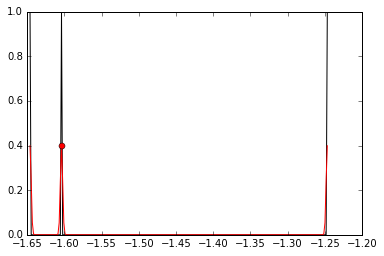

-1.60389295703
0.0248947083634


In [25]:
print thresholds_before
finalThreshold_before = get_threshold(thresholds_before)
print finalThreshold_before
finalThreshold_before = pow(10,finalThreshold_before)
print finalThreshold_before

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


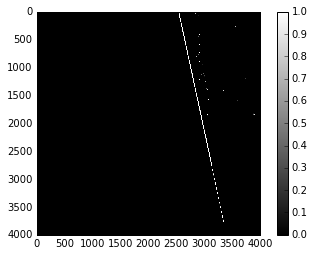

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


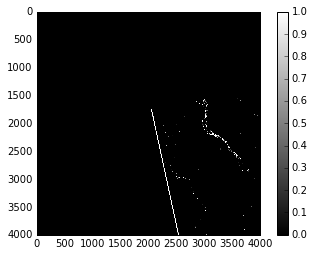

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


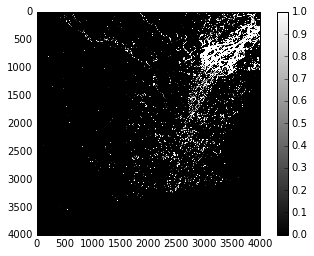

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


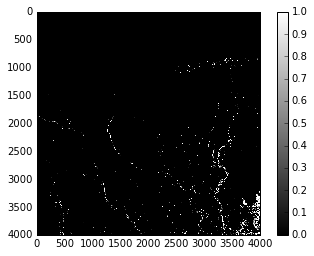

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


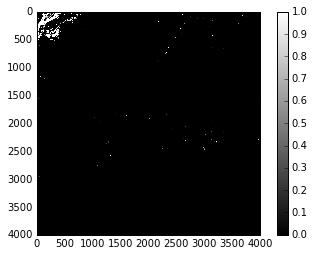

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


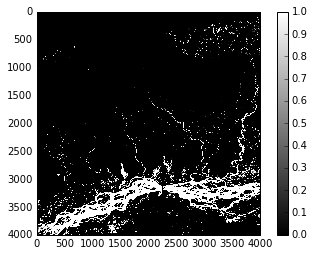

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


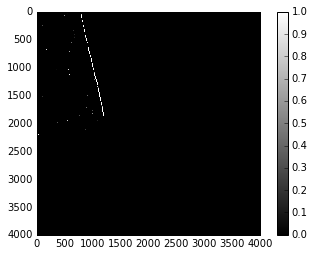

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000


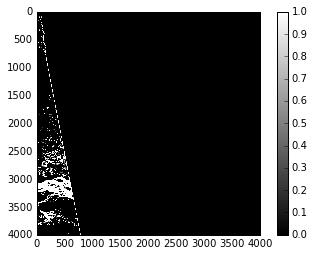

In [26]:
for tile in tiles_before:
    tileDataset = getDatasetFromTile(tile)
    showDataset(tileDataset, finalThreshold_before)

In [27]:
def showFlood(data_before, data_after, threshold_before, threshold_after):
    matrix_before = np.reshape(data_before.get(data.keys()[0]), (-1, 4000))
    matrix_after = np.reshape(data_after.get(data.keys()[0]), (-1, 4000))
    plt.figure()
    thresh_before = (matrix_before[:, :] > 0) & (matrix_before[:, :] < threshold_before)
    thresh_after = (matrix_after[:, :] > 0) & (matrix_after[:, :] < threshold_after)
    result = 3*((thresh_before[:, :] == 0) & (thresh_after[:, :] == 1)) + 2*((thresh_before[:, :] == 1) & (thresh_after[:, :] == 0)) + 1*((thresh_before[:, :] == 1) & (thresh_after[:, :] == 1))
    plt.imshow(result, cmap=plt.cm.get_cmap('gnuplot'))
    plt.colorbar()
    plt.show()
    plt.close()

#### At the end, we compare tiles before and after the event to display flooded areas
#### Black = None (no water before, no water after)
#### Purple = Permanent water (water before, water after)
#### Red = Dried area (water before, no water after)
#### Yellow = Flooded area (no water before, water after)

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


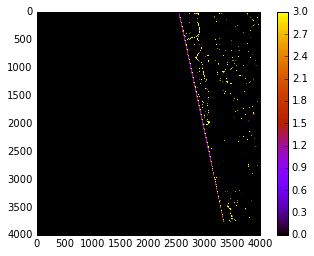

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


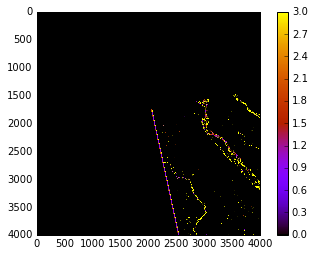

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


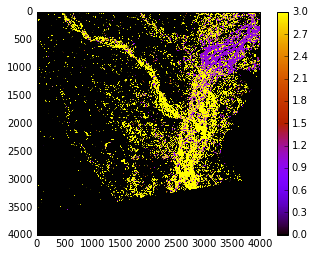

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


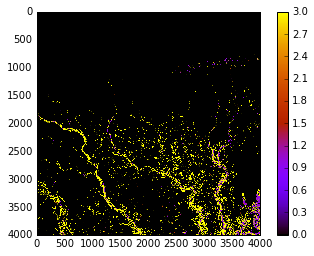

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


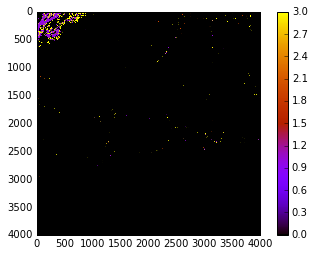

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


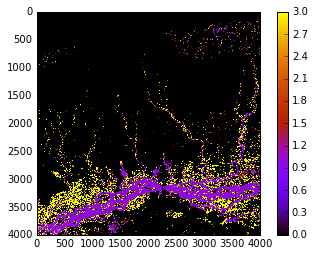

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


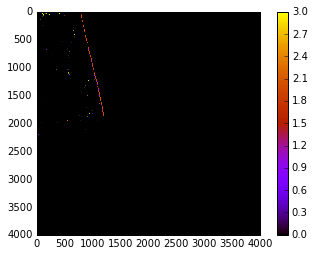

Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-06-22T12-04-41.816145.tif
Array dimensions:
x: 4000 & y: 4000
Tile file path location: /root/datacube/data/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


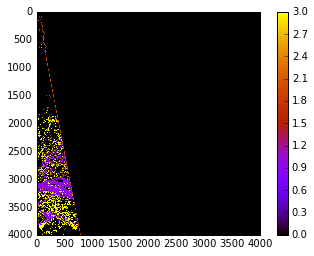

In [28]:
for i in range(0, 8):
    data_before = getDatasetFromTile(tiles_before[i])
    data_after = getDatasetFromTile(tiles[i])
    threshold_before = finalThreshold_before
    threshold_after = finalThreshold
    showFlood(data_before, data_after, threshold_before, threshold_after)